In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline

import tensorflow as tf
import edward as ed

from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import drugs as mgds_drugs
from mgds.data_modeling.nbfn import model_mkl05_lib as lib
from ml.api import trainer as ml_trainer
from ml.edward import models as ed_models

# Disable gpu usage
ed_models.set_default_gpu_config(device_count=0)

SEED = lib.SEED

2017-06-11 08:44:42,575:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')

2017-06-11 08:44:45,557:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-06-11 08:45:11,736:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-06-11 08:45:17,393:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107


In [3]:
X_rppa.head()

A1BG       A2M     A2ML1    A4GALT     A4GNT      AAAS  \
TCGA-A1-A0SH-01  0.870605  0.559730 -0.367295  0.328778  0.758833 -0.487438   
TCGA-A1-A0SJ-01  0.872559  1.102547 -0.148141  1.264884  0.666648 -1.213378   
TCGA-A1-A0SK-01 -1.013238 -1.560533 -0.437319 -1.815881 -0.616431  0.474611   
TCGA-A1-A0SO-01  2.024414 -1.528715 -0.209345 -1.922070 -0.421866 -0.455157   
TCGA-A2-A04N-01 -0.093212 -0.317896 -0.105897 -1.040180 -0.299182 -0.376301   

                     AACS     AADAC   AADACL2     AADAT    ...       ZSWIM7  \
TCGA-A1-A0SH-01 -0.367847 -0.381866  0.429928  0.491078    ...    -1.155395   
TCGA-A1-A0SJ-01 -0.492549  0.396224  0.215424  0.272124    ...     0.746362   
TCGA-A1-A0SK-01  2.052741 -1.359082  4.724143  1.757632    ...     0.648397   
TCGA-A1-A0SO-01 -1.216844 -0.127306 -0.205504  3.406434    ...     0.267998   
TCGA-A2-A04N-01 -1.045070 -0.420190 -0.094920  0.404800    ...     1.210438   

                   ZSWIM8     ZUFSP     ZWINT      ZXDC    ZYG11A    ZYG11B  \
TCGA-A1-A0SH-01 -0.594546 -0.706952 -1.039229 -0.944414 -1.075430  0.448913   
TCGA-A1-A0SJ-01  0.208179  1.562000 -0.486746 -0.965194 -0.809305  0.319753   
TCGA-A1-A0SK-01  0.106865  1.162083  1.161790  0.648071  0.299535  1.058283   
TCGA-A1-A0SO-01 -0.075633  1.003455  0.584886 -2.791125  0.129313  1.570114   
TCGA-A2-A04N-01 -0.350424  0.544582 -0.406891 -1.094822 -0.220411 -0.188337   

                      ZYX     ZZEF1      ZZZ3  
TCGA-A1-A0SH-01  1.112932  0.073506 -0.164467  
TCGA-A1-A0SJ-01 -0.747920 -0.594728 -0.838861  
TCGA-A1-A0SK-01 -2.988537 -0.273973  0.356013  
TCGA-A1-A0SO-01 -1.281026 -1.388816 -0.516795  
TCGA-A2-A04N-01 -2.468727  0.270728  1.253623  

[5 rows x 13415 columns]

In [4]:
Y_rppa.head()

ABL1   ACACA  ACVRL1    ADAR    AKT1    AKT2    AKT3  \
TCGA-A1-A0SH-01  0.1414  1.7752 -0.2407 -0.7190  0.7654  0.7654  0.7654   
TCGA-A1-A0SJ-01 -1.0458  0.3505 -0.1300 -0.5828  0.0138  0.0138  0.0138   
TCGA-A1-A0SK-01 -0.3807 -0.9959 -0.6685  0.8784 -0.3473 -0.3473 -0.3473   
TCGA-A1-A0SO-01 -0.2390  0.6525 -0.7010  0.9611  1.0870  1.0870  1.0870   
TCGA-A2-A04N-01  0.6021 -1.1306  0.8882 -0.4393 -0.0384 -0.0384 -0.0384   

                  ANXA1   ANXA7      AR   ...      TSC2  TUBA1B   WWTR1  \
TCGA-A1-A0SH-01  0.4182 -0.5345  0.0724   ...   -0.1415 -0.4113 -0.4335   
TCGA-A1-A0SJ-01 -0.3603 -0.0939 -0.0813   ...   -0.9173  0.6643 -0.2490   
TCGA-A1-A0SK-01  2.9900 -1.6245 -1.5832   ...   -0.8886  1.1055 -1.0175   
TCGA-A1-A0SO-01 -0.0437 -0.9322 -1.8314   ...    0.2309  2.1998  0.0856   
TCGA-A2-A04N-01  1.0340  0.7484 -0.1937   ...   -0.9436  0.1995  0.6093   

                   XBP1   XRCC1   XRCC5    YAP1    YBX1   YWHAB   YWHAZ  
TCGA-A1-A0SH-01 -0.1147 -0.2647  0.2348 -0.2456 -0.1099 -0.3763 -0.6884  
TCGA-A1-A0SJ-01 -0.3291 -0.9635 -0.5291  0.7098 -0.0326  0.5145  0.2628  
TCGA-A1-A0SK-01 -0.3598  1.9310  1.0458 -1.1998 -0.5646 -0.2280  1.2399  
TCGA-A1-A0SO-01 -0.1162  1.7869  1.4647 -0.6514  0.2517 -1.1367 -0.2812  
TCGA-A2-A04N-01 -0.3324 -0.7949 -0.9460  0.4596 -0.7023 -0.1742  0.4311  

[5 rows x 169 columns]

In [5]:
X_drug, Y_drug_all = mkl.get_rx_modeling_data(
    drugs=None, genes=X_rppa.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)

2017-06-11 08:45:17,468:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-06-11 08:45:33,405:INFO:mgds.data_modeling.nbfn.mkl: Removing 39 drugs of 251 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


In [6]:
# Select drugs showing sensitivity
def categorize_drug(v):
    
    if float(len(v.dropna())) / len(v) <= .8:
        return 'Not Enough Data'
    v = v.dropna()
    
    pct_sensitive = (v <= -1).sum() / float(len(v))
    if pct_sensitive <= .1:
        return 'Not Enough Sensitive Results'
    if pct_sensitive >= .8:
        return 'Too Many Sensitive Results'
    return 'Applicable'
d_cat = Y_drug_all.apply(categorize_drug)
print(d_cat.value_counts())

target_drugs = list(d_cat[d_cat == 'Applicable'].index.values)

Y_drug = Y_drug_all[target_drugs]

target_drugs

Not Enough Sensitive Results    158
Applicable                       28
Too Many Sensitive Results       14
Not Enough Data                  12
dtype: int64


['17AAG',
 'AR42',
 'AT7519',
 'AZD7762',
 'AZD8055',
 'BELINOSTAT',
 'BLEOMYCIN',
 'CEP701',
 'CUDC101',
 'DOXORUBICIN',
 'EKB569',
 'FK866',
 'GEMCITABINE',
 'ISPINESIBMESYLATE',
 'JNK9L',
 'MIDOSTAURIN',
 'MITOMYCIN',
 'OBATOCLAX',
 'PD0325901',
 'PI103',
 'RTRAIL',
 'SHIKONIN',
 'SNX2112',
 'TEMSIROLIMUS',
 'THZ21021',
 'TRAMETINIB',
 'TW37',
 'WZ3105']

In [7]:
X_drug.head()

A1BG     A2M   A2ML1  A4GALT   A4GNT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.7203  0.2146  1.4553 -0.6623 -0.5925   
BT20              BREAST            -0.7066 -0.5051  0.6345 -0.9157  0.5173   
BT474             BREAST            -1.2665 -0.4155 -0.3491 -0.2819 -0.3083   
BT483             BREAST             0.6909 -0.2528 -0.1435  0.7511 -0.9741   
BT549             BREAST             1.3433 -0.3780 -0.1978  0.1811 -0.4132   

                                       AAAS    AACS   AADAC  AADACL2   AADAT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                            
AU565             BREAST             1.8444  1.6000 -0.0267  -0.5664 -0.6264   
BT20              BREAST            -0.0836  0.8155 -0.4130   0.6665 -1.7076   
BT474             BREAST            -0.5347  0.1965 -0.3221  -0.6366 -0.1124   
BT483             BREAST            -0.9885  0.6537 -0.2252  -0.0677  0.2028   
BT549             BREAST             0.5231 -2.0494 -0.5520   0.4526 -1.0863   

                                      ...    ZSWIM7  ZSWIM8   ZUFSP   ZWINT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS   ...                                     
AU565             BREAST              ...   -0.2793  1.1833 -1.2331  0.5023   
BT20              BREAST              ...    0.8696 -0.6261  1.2621  0.1898   
BT474             BREAST              ...    0.4439 -0.2313  0.9465  0.5027   
BT483             BREAST              ...   -1.5697  1.1608 -2.0656 -0.2537   
BT549             BREAST              ...    0.0519  2.3173 -1.1863  0.4942   

                                       ZXDC  ZYG11A  ZYG11B     ZYX   ZZEF1  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.4632 -0.6045 -0.2863  1.3912  0.7169   
BT20              BREAST             0.4799  1.4424 -0.7454  0.7373  0.4954   
BT474             BREAST             0.7172  0.3457  0.1203 -0.7041  0.0264   
BT483             BREAST             0.5563  2.1898 -0.2794 -0.4491 -1.5841   
BT549             BREAST            -1.3656  1.4917 -0.7009  1.2634  1.5981   

                                       ZZZ3  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS          
AU565             BREAST            -1.8807  
BT20              BREAST             0.5627  
BT474             BREAST             0.1635  
BT483             BREAST            -2.1715  
BT549             BREAST             0.1064  

[5 rows x 13415 columns]

In [8]:
Y_drug.head()

17AAG      AR42    AT7519   AZD7762  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -2.239748 -1.023212 -0.159663 -0.529487   
BT20              BREAST            -0.867087  1.088658  0.212099  0.937712   
BT474             BREAST            -3.320525  0.774300  1.207616  2.738950   
BT483             BREAST             0.356745  6.112678  3.811822  3.818782   
BT549             BREAST            -1.858953       NaN       NaN -0.814130   

                                      AZD8055  BELINOSTAT  BLEOMYCIN  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                    
AU565             BREAST             0.273267   -0.568920   0.946870   
BT20              BREAST             0.084981    1.270848   0.819087   
BT474             BREAST             0.463185    1.243263   6.664339   
BT483             BREAST             0.818342    5.699988   7.399005   
BT549             BREAST             1.471571         NaN        NaN   

                                       CEP701   CUDC101  DOXORUBICIN  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                    
AU565             BREAST             0.220690 -1.420825    -2.014399   
BT20              BREAST             0.490009  0.252424     0.098678   
BT474             BREAST             0.508437  0.567281    -0.353971   
BT483             BREAST             2.796737  6.241743     2.159909   
BT549             BREAST            -1.284329       NaN          NaN   

                                       ...     PD0325901     PI103    RTRAIL  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS    ...                                     
AU565             BREAST               ...     -1.769833  3.156637  0.341073   
BT20              BREAST               ...     -0.478005  0.011318 -0.097948   
BT474             BREAST               ...      0.698121 -1.066502  0.571110   
BT483             BREAST               ...      2.408612  0.028027  2.174314   
BT549             BREAST               ...      1.134145       NaN  0.900967   

                                     SHIKONIN   SNX2112  TEMSIROLIMUS  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                     
AU565             BREAST            -0.310010  0.528462     -2.715029   
BT20              BREAST             0.779973  1.429839     -1.871759   
BT474             BREAST            -1.455195 -1.544080     -1.261573   
BT483             BREAST             2.220945  2.271654     -2.012491   
BT549             BREAST                  NaN       NaN     -2.919744   

                                     THZ21021  TRAMETINIB      TW37    WZ3105  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                            
AU565             BREAST            -3.709298         NaN -0.937054 -1.095889  
BT20              BREAST            -1.367966   -0.750562 -0.332228  0.519209  
BT474             BREAST            -1.421663    2.865382  1.309729 -0.836517  
BT483             BREAST             1.438521    4.427726  2.380536  1.036819  
BT549             BREAST                  NaN   -0.388891 -0.196668       NaN  

[5 rows x 28 columns]

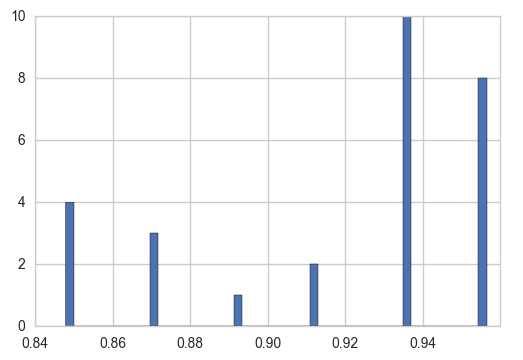

In [9]:
(Y_drug.notnull().sum(axis=0) / len(Y_drug)).hist(bins=50)

In [10]:
X_drug.shape, Y_drug.shape

((46, 13415), (46, 28))

In [11]:
X_rppa.shape, Y_rppa.shape

((403, 13415), (403, 169))

In [12]:
df_rppa.shape

(1105, 90637)

In [13]:
np.any(X_drug.isnull())

False

In [14]:
Y_drug.isnull().sum().sum() / Y_drug.values.ravel().shape[0]

0.081521739130434784

In [15]:
from sklearn.preprocessing import Imputer
Y_drug_imp = pd.DataFrame(Imputer(strategy='mean').fit_transform(Y_drug), index=Y_drug.index, columns=Y_drug.columns)

In [16]:
np.any(Y_drug_imp.isnull())

False

In [17]:
np.any(X_rppa.isnull())

False

In [18]:
np.any(Y_rppa.isnull())

False

In [19]:
# # Optional split for rppa prediction validation
# from sklearn.model_selection import train_test_split
# X_rppa, X_rppa_test, Y_rppa, Y_rppa_test = train_test_split(X_rppa, Y_rppa, test_size=.1)

# Sensitivity Modeling

In [20]:
# import imp
# imp.reload(mklmodel)
# imp.reload(ed_models)

In [60]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from ml.api import trainer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from collections import OrderedDict

rxcv_dir_fmt = lib.mpath('rxcv/{}')
    
ests = OrderedDict({
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
    
#     'lasso': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(LassoCV(alphas=np.linspace(.06, 1., num=10), random_state=SEED)))
#     ]),
    
#     'pcareg': lambda i: GridSearchCV(Pipeline([
#         ('scale', StandardScaler()),
#         ('pca', PCA(random_state=SEED)),
#         ('est', MultiOutputRegressor(LinearRegression()))
#     ]), {'pca__n_components': [3, 5, 10, 15, 20]}),
    
#     'svr': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 6, 10)})))
#     ]),
    
    'mkl': lib.get_mkl_model_fn(rxcv_dir_fmt, (X_rppa, Y_rppa)),
    
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
})

#cv = KFold(n_splits=5, random_state=SEED, shuffle=True).split(X_drug)
cv = KFold(n_splits=10, random_state=SEED, shuffle=True).split(X_drug)

d_drug_rppa_pred = []

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, refit):
    global d_drug_rppa_pred
    if est_name == 'mkl':
        est = est.fit(X_train.values, Y_train.values)
        
        # Generate RPPA predictions on cell lines and add to global list
        if not refit:
            X_drug_rppa = est.model.x_drug_scaler.transform(X_test)
            Y_drug_rppa = pd.DataFrame(
                est.criticism_args_['pred_rppa_fn'](X_drug_rppa, scale=False), 
                index=X_test.index, columns=Y_rppa.columns
            )
            d_drug_rppa_pred.append(Y_drug_rppa)

        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [61]:
rmdir = rxcv_dir_fmt.format('*')
! rm -rf $rmdir
train_res = cv_trainer.train_regressors(X_drug, Y_drug_imp, ests, cv)

2017-06-11 08:59:45,315:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (41, 13415), dim(X_test) = (5, 13415), dim(Y_train) = (41, 28), dim(Y_test) = (5, 28)
2017-06-11 08:59:45,335:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (41, 13415), dim(X_test) = (5, 13415), dim(Y_train) = (41, 28), dim(Y_test) = (5, 28)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-06-11 08:59:47,279:INFO:root: On iteration 0 of at most 5000 (loss = 13621162.0, loss change = None)
2017-06-11 08:59:49,122:INFO:root: On iteration 500 of at most 5000 (loss = 4184796.5, loss change = -7509.125)
2017-06-11 08:59:51,056:INFO:root: On iteration 1000 of at most 5000 (loss = 2085276.375, loss change = -2100.4375)
2017-06-11 08:59:52,974:INFO:root: On iteration 1500 of at most 5000 (loss = 1311065.5, loss change = -1208.0250244140625)
2017-06-11 08:59:54,971:INFO:root: On iteration 2000 of at most 5000 (loss = 950167.0625, loss change = -446.0874938964844)
2017-06-11 08:59:57,105:INFO:root: On iteration 2500 of at most 5000 (loss = 756182.3125, loss change = -361.4750061035156)
2017-06-11 08:59:59,251:INFO:root: On iteration 3000 of at most 5000 (loss = 638552.375, loss change = 28.96875)
2017-06-11 09:00:01,466:INFO:root: On iteration 3500 of at most 5000 (loss = 564169.625, loss change = -34.28125)
2017-06-11 09:00:03,609:INFO:root: On iteration 4000 of at most 5000

Beginning model refitting


2017-06-11 09:02:53,238:INFO:root: On iteration 0 of at most 5000 (loss = 13628032.0, loss change = None)
2017-06-11 09:02:55,112:INFO:root: On iteration 500 of at most 5000 (loss = 4220514.0, loss change = -7399.2001953125)
2017-06-11 09:02:56,997:INFO:root: On iteration 1000 of at most 5000 (loss = 2134705.75, loss change = -2310.39990234375)
2017-06-11 09:02:59,016:INFO:root: On iteration 1500 of at most 5000 (loss = 1354269.375, loss change = -1288.5625)
2017-06-11 09:03:01,042:INFO:root: On iteration 2000 of at most 5000 (loss = 984167.875, loss change = -367.2562561035156)
2017-06-11 09:03:03,068:INFO:root: On iteration 2500 of at most 5000 (loss = 786745.1875, loss change = -485.5687561035156)
2017-06-11 09:03:05,114:INFO:root: On iteration 3000 of at most 5000 (loss = 668440.5, loss change = -61.381248474121094)
2017-06-11 09:03:07,121:INFO:root: On iteration 3500 of at most 5000 (loss = 591811.0, loss change = -237.59375)
2017-06-11 09:03:07,898:INFO:root: Converged on iterati

In [22]:
#est = properties.extract_refit_model_map(train_res)['pcareg']

In [62]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
AU565             BREAST            -2.239748     1  baseline  -0.854823   
BT20              BREAST            -0.867087     1  baseline  -0.854823   
EFM19             BREAST            -0.957216     1  baseline  -0.854823   
JIMT1             BREAST            -2.881099     1  baseline  -0.854823   
MDAMB157          BREAST            -2.039044     1  baseline  -0.854823   

                                      Task  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS         
AU565             BREAST             17AAG  
BT20              BREAST             17AAG  
EFM19             BREAST             17AAG  
JIMT1             BREAST             17AAG  
MDAMB157          BREAST             17AAG

In [63]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']

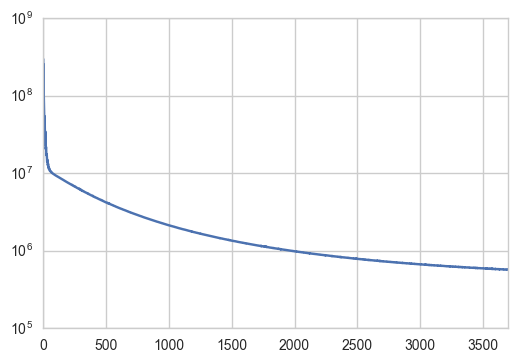

In [64]:
ax = pd.Series(est.clf.losses_[:]).plot()
ax.set_yscale('symlog')

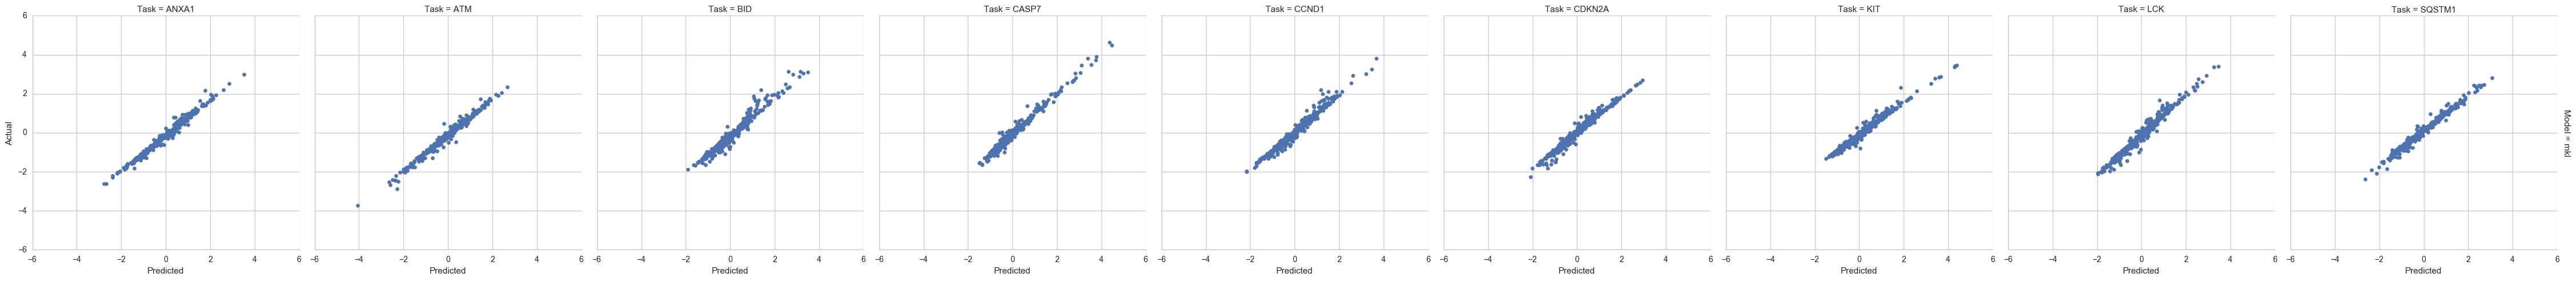

In [65]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Y_rppa.index, columns=Y_rppa.columns)
d_pred_train = mkl.stack_predictions(Yp, Y_rppa).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=True)
g.savefig(lib.rpath('pred_train_rppa.png'))

In [28]:
# Predictions on RPPA test data (moved to RPPA CV section)

# Yp = pd.DataFrame(est.clf.criticism_args_['pred_rppa_fn'](X_rppa_test.values), index=Y_rppa_test.index, columns=Y_rppa_test.columns)
# d_pred_test = mkl.stack_predictions(Yp, Y_rppa_test).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})

# tasks = d_pred_test['Task'].unique()
# Got most variable tasks by prediction std
#tasks = d_pred_test.groupby('Task')['Predicted'].std().sort_values().tail(40).index.values
#g = predictions.visualize(train_res, d_pred_test[d_pred_test['Task'].isin(tasks)], share_axes=True)
#g.savefig(rpath('pred_test_rppa.png'))

In [29]:
# d_rppa_score = d_pred_test.groupby('Task').apply(lambda g: g['Predicted'].corr(g['Actual']))
# print(d_rppa_score.describe())
# d_rppa_score.hist(bins=30)

In [66]:
qYRDsd = pd.Series(est.clf.get_tensor('qYRD_sd')[0], index=Y_rppa.columns)

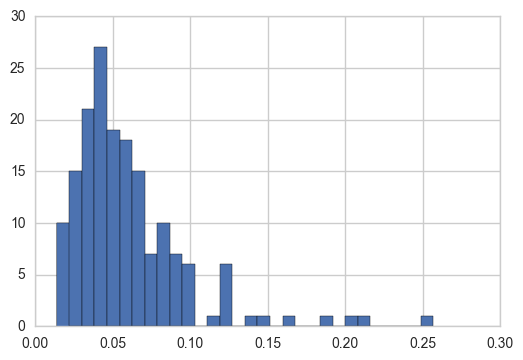

In [67]:
qYRDsd.hist(bins=30)

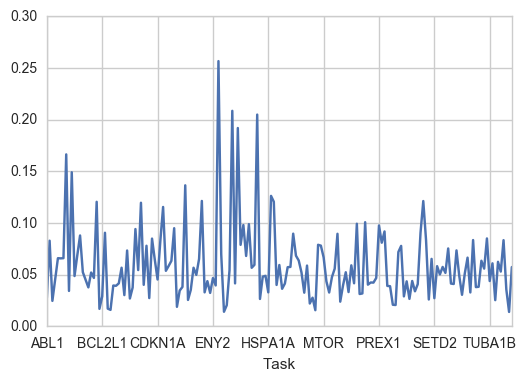

In [68]:
qYRDsd.plot()

In [69]:
qYRDsd.sort_values().tail(50)

Task
SYK        0.066469
MTOR       0.066711
FOXO3      0.068104
LCK        0.068369
ARID1A     0.068712
ERBB3      0.069762
RAB25      0.071917
CASP7      0.073375
SRSF1      0.073481
SNAI1      0.075361
RAD50      0.077820
CDH1       0.077981
MSH6       0.078104
FN1        0.078861
MSH2       0.078911
PRKAA1     0.080932
CDKN1B     0.082583
ACACA      0.082858
YAP1       0.083384
RPTOR      0.083461
TGM2       0.083497
CDH3       0.084911
TSC2       0.085054
ASNS       0.087922
NOTCH1     0.089556
KIT        0.089673
RPS6KA1    0.090462
BCL2L11    0.090549
PRKCA      0.091834
CCNB1      0.094147
COG3       0.094967
PREX1      0.097616
FOXM1      0.098035
G6PD       0.098910
PDK1       0.099289
PGR        0.100780
CDKN2A     0.115521
CCNE1      0.119601
BCL2       0.120502
INPP4B     0.120577
RPS6KB1    0.121245
EGFR       0.121344
IGFBP2     0.126230
DIABLO     0.136463
AR         0.149105
ANXA1      0.166400
FASN       0.191918
GATA3      0.204901
ESR1       0.208536
ERBB2      0.25

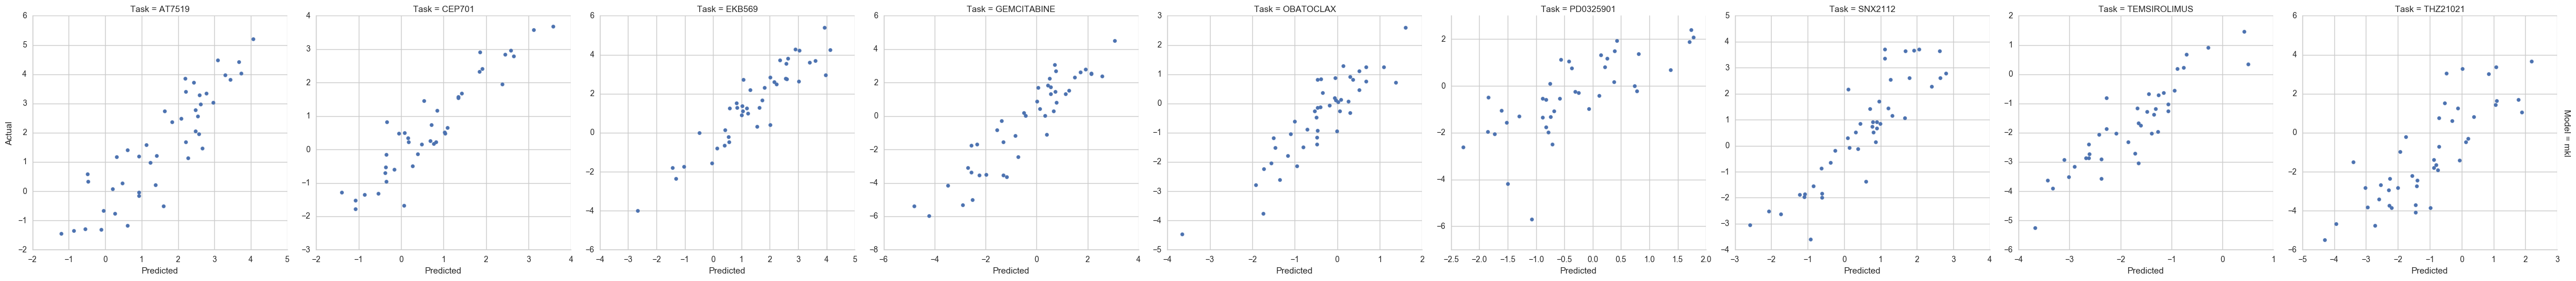

In [32]:
# Predictions on drug training data
Yp = est.clf.predict(X_drug.values)
d_pred_train = mkl.stack_predictions(Yp, Y_drug).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)
g.savefig(lib.rpath('pred_train_drug.png'))

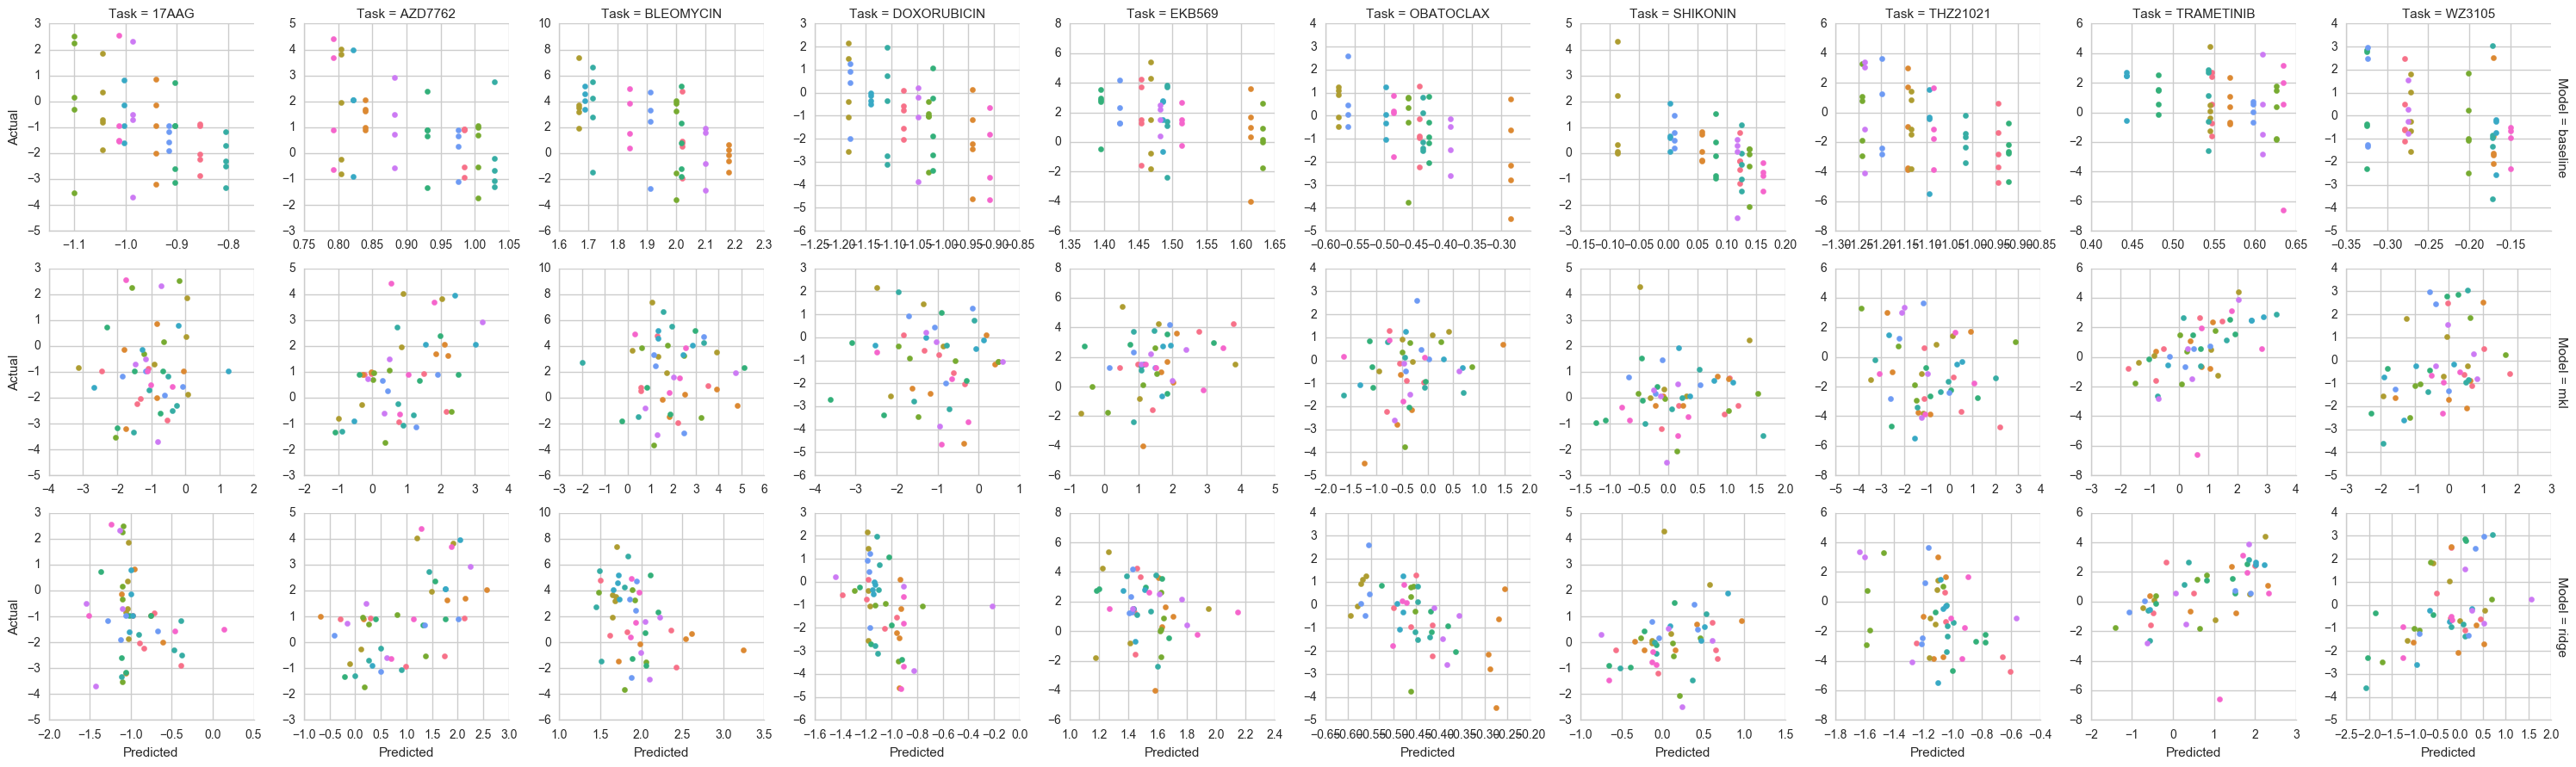

In [71]:
tasks = d_pred_melt['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)
g.savefig(lib.rpath('pred_test_drug_sample.png'))

In [72]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
        #'n': len(y_pred.dropna())
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.467037
1  baseline  All  17AAG   pearson_p  0.001067
2  baseline  All  17AAG    r2_score -0.054957
3  baseline  All  17AAG    spearman -0.493887
4  baseline  All  17AAG  spearman_p  0.000486

In [73]:
from py_utils import plotly_utils
figs = performance.visualize(d_score, separate_by='Metric', kind='scatter', auto_plot=False)
for metric in figs:
    filename = lib.rpath('perf_scatter_{}.html'.format(metric))
    plty.offline.plt(figs[metric], filename=filename)
    print(filename)
[plotly_utils.iplot(fig) for fig in figs.values()]

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_r2_score.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_pearson_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_pearson.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_spearman.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_scatter_spearman_p.html


[None, None, None, None, None]

In [74]:
lib.plot_performance_metric(d_score, filename='perf_box', plot_in_notebook=True)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_all.html


In [75]:
lib.plot_performance_metric(d_score, filename='perf_box', metric='pearson')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_pearson.html


In [76]:
lib.plot_performance_metric(d_score, filename='perf_box', metric='spearman')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_spearman.html


In [77]:
lib.plot_performance_metric(d_score, filename='perf_box', metric='pearson_p')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_box_pearson_p.html


# Drug Selection

Based on performance above:

In [78]:
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.467037
1  baseline  All  17AAG   pearson_p  0.001067
2  baseline  All  17AAG    r2_score -0.054957
3  baseline  All  17AAG    spearman -0.493887
4  baseline  All  17AAG  spearman_p  0.000486

In [79]:
def get_most_predictable_tasks(metric, pvalue):
    assert np.all(d_score['Fold'] == 'All')
    d_top_perf = d_score.set_index(['Model', 'Task', 'Metric'])['Value'].unstack()
    d_top_perf = d_top_perf[(d_top_perf[metric] >= 0) & (d_top_perf['{}_p'.format(metric)] <= pvalue)]
    return d_top_perf
d_top_perf = get_most_predictable_tasks('pearson', .15)
d_top_perf

Metric                    pearson     pearson_p  r2_score  spearman  \
Model Task                                                            
mkl   AT7519             0.297436  4.469898e-02 -0.023512  0.300225   
      AZD7762            0.453491  1.550040e-03  0.152269  0.454700   
      CEP701             0.416928  3.945867e-03  0.131654  0.351906   
      EKB569             0.292977  4.815701e-02  0.039138  0.271067   
      FK866              0.254355  8.804013e-02 -0.071207  0.285785   
      ISPINESIBMESYLATE  0.650502  9.903184e-07  0.421002  0.566222   
      JNK9L              0.238943  1.097643e-01 -0.037591  0.163017   
      MIDOSTAURIN        0.239650  1.086862e-01 -0.114433  0.293777   
      OBATOCLAX          0.233528  1.182972e-01  0.000865  0.179777   
      PI103              0.381412  8.913380e-03  0.121840  0.386788   
      RTRAIL             0.333188  2.365532e-02  0.008580  0.268858   
      TRAMETINIB         0.566822  4.011111e-05  0.317579  0.659284   
      WZ3105             0.356961  1.488271e-02  0.074563  0.393573   
ridge AT7519             0.470271  9.742588e-04  0.220620  0.494619   
      AZD7762            0.554903  6.278161e-05  0.307096  0.560828   
      CEP701             0.394305  6.697275e-03  0.150212  0.357463   
      FK866              0.373060  1.066449e-02  0.134682  0.361784   
      ISPINESIBMESYLATE  0.609930  6.801618e-06  0.360766  0.622961   
      MIDOSTAURIN        0.324077  2.800726e-02  0.082914  0.349658   
      PD0325901          0.305794  3.876100e-02  0.088393  0.409033   
      PI103              0.429603  2.887143e-03  0.181867  0.430580   
      RTRAIL             0.268063  7.167486e-02  0.048825  0.313267   
      SHIKONIN           0.309602  3.627923e-02  0.093196  0.371862   
      TRAMETINIB         0.522402  1.960629e-04  0.266012  0.631894   
      WZ3105             0.472660  9.101807e-04  0.222118  0.460186   

Metric                     spearman_p  
Model Task                             
mkl   AT7519             4.264002e-02  
      AZD7762            1.500217e-03  
      CEP701             1.646992e-02  
      EKB569             6.843154e-02  
      FK866              5.419034e-02  
      ISPINESIBMESYLATE  4.104415e-05  
      JNK9L              2.790435e-01  
      MIDOSTAURIN        4.752153e-02  
      OBATOCLAX          2.318826e-01  
      PI103              7.922387e-03  
      RTRAIL             7.080426e-02  
      TRAMETINIB         6.280741e-07  
      WZ3105             6.808851e-03  
ridge AT7519             4.756114e-04  
      AZD7762            5.035593e-05  
      CEP701             1.473237e-02  
      FK866              1.349111e-02  
      ISPINESIBMESYLATE  3.773402e-06  
      MIDOSTAURIN        1.722091e-02  
      PD0325901          4.765413e-03  
      PI103              2.817036e-03  
      RTRAIL             3.401524e-02  
      SHIKONIN           1.093836e-02  
      TRAMETINIB         2.480243e-06  
      WZ3105             1.291517e-03

In [80]:
pd.set_option('display.max_rows', 10000)
d_top_perf.reset_index().groupby('Task')['Model'].unique()

Task
AT7519               [mkl, ridge]
AZD7762              [mkl, ridge]
CEP701               [mkl, ridge]
EKB569                      [mkl]
FK866                [mkl, ridge]
ISPINESIBMESYLATE    [mkl, ridge]
JNK9L                       [mkl]
MIDOSTAURIN          [mkl, ridge]
OBATOCLAX                   [mkl]
PD0325901                 [ridge]
PI103                [mkl, ridge]
RTRAIL               [mkl, ridge]
SHIKONIN                  [ridge]
TRAMETINIB           [mkl, ridge]
WZ3105               [mkl, ridge]
Name: Model, dtype: object

In [81]:
d_top_perf.loc['ridge'].index.get_level_values('Task')

Index(['AT7519', 'AZD7762', 'CEP701', 'FK866', 'ISPINESIBMESYLATE',
       'MIDOSTAURIN', 'PD0325901', 'PI103', 'RTRAIL', 'SHIKONIN', 'TRAMETINIB',
       'WZ3105'],
      dtype='object', name='Task')

In [82]:
d_top_perf.loc['pcareg'].index.get_level_values('Task')

KeyError: 'the label [pcareg] is not in the [index]'

In [58]:
d_top_perf.loc['lasso'].index.get_level_values('Task')

Index(['AZD7762', 'CEP701', 'GEMCITABINE', 'ISPINESIBMESYLATE', 'RTRAIL',
       'TRAMETINIB', 'TW37'],
      dtype='object', name='Task')

In [83]:
top_drugs = d_top_perf.loc['mkl'].index.get_level_values('Task')
top_drugs

Index(['AT7519', 'AZD7762', 'CEP701', 'EKB569', 'FK866', 'ISPINESIBMESYLATE',
       'JNK9L', 'MIDOSTAURIN', 'OBATOCLAX', 'PI103', 'RTRAIL', 'TRAMETINIB',
       'WZ3105'],
      dtype='object', name='Task')

# Effects

In [84]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']
qW = est.clf.get_tensor('qW_scale')
#qW = est.clf.get_tensor('qW')

In [85]:
W = pd.DataFrame(qW, index=Y_rppa.columns, columns=Y_drug.columns)
W.index.name = 'RPPA'
W.columns.name = 'Drug'
W.head()

Drug       17AAG      AR42    AT7519   AZD7762   AZD8055  BELINOSTAT  \
RPPA                                                                   
ABL1    0.008202  0.000153 -0.003502  0.008344  0.008070    0.000351   
ACACA   0.005370 -0.045635 -0.013298  0.013278  0.005898   -0.045402   
ACVRL1  0.009734  0.003364 -0.002551  0.007192  0.000436    0.002578   
ADAR    0.010067  0.007764 -0.007889  0.011808  0.020140    0.006299   
AKT1   -0.010072  0.012054  0.005222 -0.003491  0.005064    0.008635   

Drug    BLEOMYCIN    CEP701   CUDC101  DOXORUBICIN    ...     PD0325901  \
RPPA                                                  ...                 
ABL1     0.001163  0.003041  0.000095    -0.001425    ...      0.003451   
ACACA   -0.011029  0.019558 -0.048986     0.006306    ...      0.023696   
ACVRL1   0.012470  0.009422  0.001916     0.004178    ...     -0.001243   
ADAR     0.011503  0.018350  0.005873     0.003975    ...      0.008770   
AKT1     0.010317  0.001542  0.005858     0.002261    ...     -0.002049   

Drug       PI103    RTRAIL  SHIKONIN   SNX2112  TEMSIROLIMUS  THZ21021  \
RPPA                                                                     
ABL1   -0.002408  0.003832 -0.003848  0.001426      0.009764  0.004043   
ACACA  -0.014627  0.018860 -0.011043 -0.000239      0.004404  0.019790   
ACVRL1 -0.003900  0.003544  0.000708  0.004059      0.007309 -0.001279   
ADAR    0.008255  0.008148  0.011643  0.010199      0.009136  0.008900   
AKT1    0.016094  0.001270  0.008074 -0.004790      0.008045 -0.010445   

Drug    TRAMETINIB      TW37    WZ3105  
RPPA                                    
ABL1      0.005880  0.013523 -0.006622  
ACACA    -0.004410  0.002364 -0.043826  
ACVRL1    0.007832 -0.000766 -0.000579  
ADAR      0.004209  0.013376 -0.013390  
AKT1      0.014977  0.007858  0.010007  

[5 rows x 28 columns]

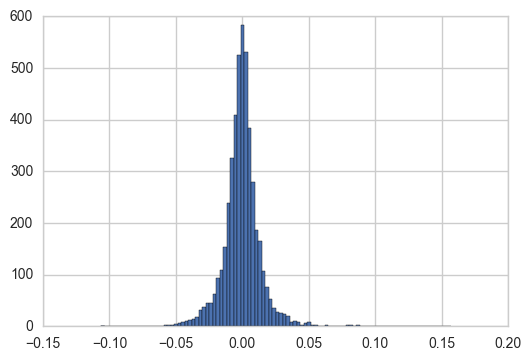

In [86]:
pd.Series(W.values.ravel()).hist(bins=100)

In [87]:
weight_cutoff = .018

In [54]:
# def plot_weights(W, cutoff, title, filename, height=600):
#     layout = dict(
#         title=title,
#         width=1000, height=height,
#         margin=dict(l=120)
#     )
#     fig = W.applymap(lambda v: np.nan if abs(v) <= cutoff else v)\
#         .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
#     fig['layout']['xaxis'].update(title='RPPA Gene')
#     fig['layout']['yaxis'].update(title='Drug')
#     filename = rpath('{}.html'.format(filename))
#     plty.offline.plt(fig, filename=filename)
#     print(filename)
#     plty.offline.iplt(fig)

In [88]:
lib.plot_weights(W, 0., 'RPPA Weights by All Tasks (ie Drugs)', filename='rppa_weight_all_nocutoff')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_all_nocutoff.html


In [89]:
lib.plot_weights(W, weight_cutoff, 'RPPA Weights by All Tasks (ie Drugs)', filename='rppa_weight_all')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_all.html


In [90]:
lib.plot_weights(
    W[top_drugs], 0., 'RPPA Weights by Predictive Tasks (ie Drugs)', 
    filename='rppa_weight_best_nocutoff', height=400
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_best_nocutoff.html


In [91]:
lib.plot_weights(
    W[top_drugs], weight_cutoff, 'RPPA Weights by Predictive Tasks (ie Drugs)', 
    filename='rppa_weight_best', height=400
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_best.html


In [92]:
lib.plot_weight_bars(W[top_drugs], filename='rppa_weight_bar')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_bar.html


In [85]:
lib.plot_weight_bars(W[top_drugs], filename='rppa_weight_bar')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/rppa_weight_bar.html


In [93]:
sorted(top_drugs.values)

['AT7519',
 'AZD7762',
 'CEP701',
 'EKB569',
 'FK866',
 'ISPINESIBMESYLATE',
 'JNK9L',
 'MIDOSTAURIN',
 'OBATOCLAX',
 'PI103',
 'RTRAIL',
 'TRAMETINIB',
 'WZ3105']

## Predictions on Sensitive

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_top_drugs_static.png'

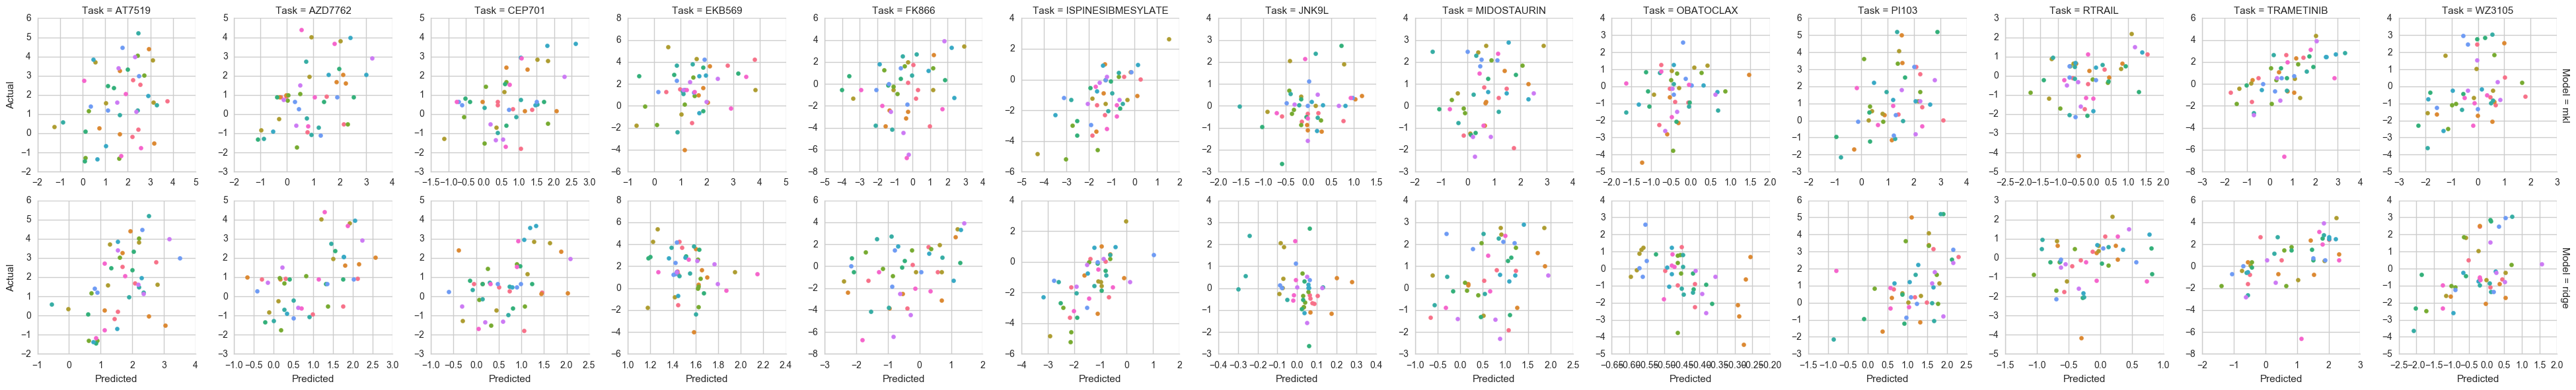

In [94]:
d_plt = d_pred_melt[d_pred_melt['Task'].isin(top_drugs)]
d_plt = d_plt[d_plt['Model'].isin(['pcareg', 'ridge', 'mkl'])]
predictions.visualize(train_res, d_plt, share_axes=False, figsize=3)
filename = lib.rpath('pred_top_drugs_static.png')
plt.savefig(filename)
filename

In [89]:
imp.reload(lib)

<module 'mgds.data_modeling.nbfn.model_mkl05_lib' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/nbfn/model_mkl05_lib.py'>

In [95]:
title='Predicted vs Actual (PCA Reg Model)<br>(Predicted on x-axis, Actual on y-axis)'
lib.plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'pcareg', title, 
    filename='pred_top_drugs_pcareg', plot_in_notebook=False
)

Exception: Keyword argument 'rows' must be an int greater than 0

In [96]:
title='Predicted vs Actual (MKL Model)<br>(Predicted on x-axis, Actual on y-axis)'
lib.plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'mkl', title, 
    filename='pred_top_drugs_mkl', plot_in_notebook=True,
    n_col=3
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_top_drugs_mkl.html


In [92]:
title='Predicted vs Actual (MKL Model)<br>(Predicted on x-axis, Actual on y-axis)'
lib.plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'mkl', title, 
    filename='pred_top_drugs_mkl', plot_in_notebook=True,
    n_col=3
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_top_drugs_mkl.html


In [97]:
def export_predictions(d_pred, drugs, model, filename=None):
    d = d_pred.copy()
    d = d[d['Task'].isin(drugs)]
    d = d[d['Model'] == model]
    d = d.reset_index().drop(['Fold', 'Model'], axis=1)
    d = d.rename(columns={'CELL_LINE_ID:MGDS': 'Cell Line Id', 'PRIMARY_SITE:MGDS': 'Primary Site', 'Task': 'Drug'})
    if filename is not None:
        filename = lib.rpath('{}.csv'.format(filename))
        print(filename)
        d.to_csv(filename, index=False)
    return d

d_exp = export_predictions(d_pred_melt, top_drugs, 'mkl', filename='pred_sensitivity_mkl_top_drugs')
d_exp.head()

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_sensitivity_mkl_top_drugs.csv


Cell Line Id Primary Site    Actual  Predicted    Drug
0        AU565       BREAST -0.159663   2.184735  AT7519
1         BT20       BREAST  0.212099   2.470709  AT7519
2        EFM19       BREAST  1.686588   3.742548  AT7519
3        JIMT1       BREAST  2.789341   2.209328  AT7519
4     MDAMB157       BREAST  2.559784   2.554273  AT7519

In [98]:
len(d_exp) / d_exp['Drug'].nunique()

46.0

In [99]:
d_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 5 columns):
Cell Line Id    598 non-null object
Primary Site    598 non-null object
Actual          598 non-null float64
Predicted       598 non-null float64
Drug            598 non-null object
dtypes: float64(2), object(3)
memory usage: 23.4+ KB


# Drug RPPA Predictions

In [100]:
d_pred_drug_rppa = pd.concat(d_drug_rppa_pred)
d_pred_drug_rppa.head()

RPPA                                     ABL1     ACACA    ACVRL1      ADAR  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.067693  0.477848 -0.038664  0.236430   
BT20              BREAST             0.120049  0.055418 -0.202221  0.220459   
EFM19             BREAST             0.017292  0.339721 -0.126285  0.315960   
JIMT1             BREAST            -0.083779  0.195344 -0.075198  0.102263   
MDAMB157          BREAST             0.090669 -0.007247 -0.065044  0.133536   

RPPA                                     AKT1      AKT2      AKT3     ANXA1  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST             0.235286  0.233538  0.235277 -0.303367   
BT20              BREAST             0.170044  0.169326  0.173172 -0.098205   
EFM19             BREAST             0.044428  0.043368  0.044912 -0.592662   
JIMT1             BREAST            -0.134526 -0.133402 -0.132502  0.095505   
MDAMB157          BREAST            -0.060491 -0.060341 -0.057940 -0.003078   

RPPA                                    ANXA7        AR    ...         TSC2  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                        ...                
AU565             BREAST            -0.066774 -0.059418    ...    -0.099454   
BT20              BREAST            -0.144634 -0.272906    ...    -0.234206   
EFM19             BREAST             0.047319  0.309496    ...     0.077661   
JIMT1             BREAST            -0.150764 -0.200139    ...    -0.212405   
MDAMB157          BREAST            -0.159703 -0.151007    ...    -0.268706   

RPPA                                   TUBA1B     WWTR1      XBP1     XRCC1  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.248738 -0.246156  0.069966 -0.239733   
BT20              BREAST            -0.262996  0.192229 -0.067707 -0.113255   
EFM19             BREAST            -0.075282 -0.141696 -0.032333  0.190346   
JIMT1             BREAST             0.172197  0.143560 -0.192056 -0.092373   
MDAMB157          BREAST             0.046759 -0.007501 -0.105033 -0.014030   

RPPA                                    XRCC5      YAP1      YBX1     YWHAB  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.153465 -0.320663 -0.156239 -0.142224   
BT20              BREAST            -0.164131 -0.137929 -0.138450 -0.093027   
EFM19             BREAST            -0.218591 -0.356076  0.062262 -0.061770   
JIMT1             BREAST            -0.365429 -0.063997  0.071815 -0.125512   
MDAMB157          BREAST            -0.232418 -0.173986  0.031745 -0.049719   

RPPA                                    YWHAZ  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS            
AU565             BREAST             0.096283  
BT20              BREAST             0.032017  
EFM19             BREAST             0.241823  
JIMT1             BREAST             0.169557  
MDAMB157          BREAST             0.138566  

[5 rows x 169 columns]

In [151]:
top_rppa_by_std = d_pred_drug_rppa.std().sort_values().tail(13)
d_pred_drug_rppa.std().sort_values().iplot(kind='bar')
top_rppa_by_std

RPPA
DIABLO     0.265723
PGR        0.266156
RPS6KB1    0.267095
INPP4B     0.283080
IGFBP2     0.289514
BCL2       0.296571
ANXA1      0.303524
FASN       0.320999
AR         0.321849
EGFR       0.330207
ESR1       0.336666
GATA3      0.381783
ERBB2      0.432968
dtype: float64

In [125]:
len(X_drug), len(d_pred_drug_rppa)

(46, 46)

In [126]:
def get_rppa_cell_line_predictions(d_pred_drug_rppa, X_drug):
    # Make sure the indexes for each dataset are equal and that they have the same length
    assert X_drug.sort_index().index.equals(d_pred_drug_rppa.sort_index().index)
    assert len(X_drug) == len(d_pred_drug_rppa)
    
    d1 = d_pred_drug_rppa.copy()
    d1.columns.name = 'GENE'
    d1 = d1.stack().rename('RPPA')
    d2 = X_drug.copy()
    d2.columns.name = 'GENE'
    d2 = d2.stack().rename('GE')
    
    return pd.concat([d1, d2], axis=1, join='outer')

d_cl_rppa = get_rppa_cell_line_predictions(d_pred_drug_rppa, X_drug)
d_cl_rppa.head()

RPPA      GE
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS GENE                
AU565             BREAST            A1BG     NaN -0.7203
                                    A2M      NaN  0.2146
                                    A2ML1    NaN  1.4553
                                    A4GALT   NaN -0.6623
                                    A4GNT    NaN -0.5925

In [127]:
# Unmatched RPPA names (ie proteins not present in gene names)
d_cl_rppa[d_cl_rppa['RPPA'].notnull() & d_cl_rppa['GE'].isnull()].reset_index()['GENE'].value_counts()

EPPK1     46
ERCC5     46
CDKN1A    46
RPTOR     46
CHEK2     46
DIABLO    46
BRCA2     46
SRSF1     46
TIGAR     46
COPS5     46
ARAF      46
EIF4G1    46
YBX1      46
DVL3      46
BAK1      46
G6PD      46
CDK1      46
AR        46
PECAM1    46
CLDN7     46
Name: GENE, dtype: int64

In [128]:
d_cl_rppa_pres = d_cl_rppa.dropna()

In [129]:
d_cl_rppa_pres.describe()
#d_cl_rppa.reset_index().groupby(['CELL_LINE_ID:MGDS', 'PRIMARY_SITE:MGDS']).size()

RPPA           GE
count  6854.000000  6854.000000
mean     -0.004588     0.060998
std       0.230055     1.297048
min      -0.802643    -7.631700
25%      -0.160053    -0.671725
50%      -0.009160    -0.026400
75%       0.144199     0.712450
max       1.016788    18.819700

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x140cd5f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15da2ca20>]], dtype=object)

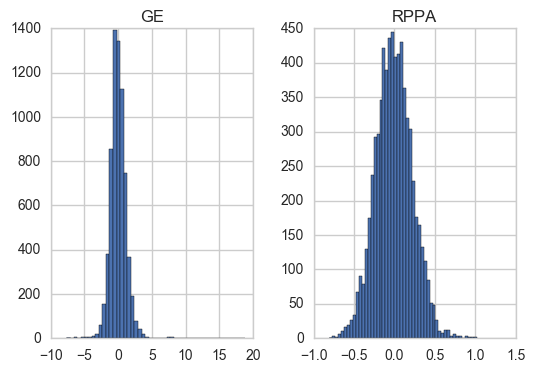

In [130]:
d_cl_rppa_pres.hist(bins=50)

Task Model      Metric      Value Fold
0  ABL1   mkl     pearson   0.187936  All
1  ABL1   mkl   pearson_p   0.000148  All
2  ABL1   mkl    r2_score -10.910698  All
3  ABL1   mkl    spearman   0.192757  All
4  ABL1   mkl  spearman_p   0.000099  All

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16b7a7e80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1658d94e0>]], dtype=object)

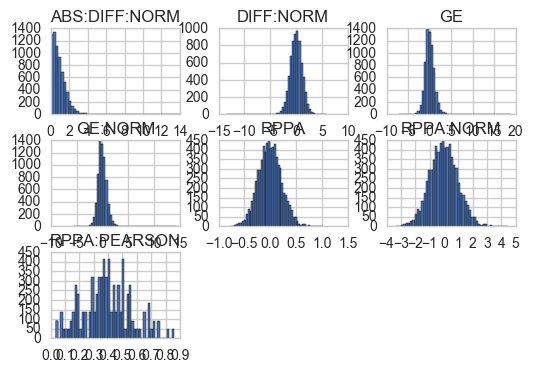

In [176]:
def get_normalized_comparison(d_cl_rppa_pres):
    
    d = d_cl_rppa_pres.copy()
    for c in d:
        v = d[c]
        d[c + ':NORM'] = (v - v.mean()) / v.std()

    d['DIFF:NORM'] = d['RPPA:NORM'] - d['GE:NORM']
    #d_cl_rppa_norm['RATIO'] = (d_cl_rppa_norm['RPPA'] / d_cl_rppa_norm['GE']).abs()
    d['ABS:DIFF:NORM'] = d['DIFF:NORM'].abs()

    return d

def add_pred_perf_scores_to_comparison(d_cl_rppa_norm):
    d = d_cl_rppa_norm.copy()
    d_perf = pd.read_csv(lib.rpath('perf_mkl_rppa_cv.csv')).query('Metric == "pearson" & Fold == "All"')
    d_perf = d_perf.set_index('Task')['Value']
    d['RPPA:PEARSON'] = pd.Series(d.index.get_level_values('GENE')).map(d_perf.to_dict()).values
    assert np.all(d['RPPA:PEARSON'].notnull())
    return d

d_cl_rppa_norm = get_normalized_comparison(d_cl_rppa_pres)
d_cl_rppa_norm = add_pred_perf_scores_to_comparison(d_cl_rppa_norm)
d_cl_rppa_norm.hist(bins=50)

### Save all comparisons

In [178]:
dt = d_cl_rppa_norm.sort_values('ABS:DIFF:NORM', ascending=False)
filename = lib.rpath('pred_rppa_vs_ge.csv')
dt.to_csv(filename, index=False)
filename

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_rppa_vs_ge.csv'

### Save comparisons for most predictable RPPA proteins

In [185]:
d_cl_rppa_norm.reset_index().groupby('GENE')['RPPA:PEARSON'].first().sort_values().tail(16)

GENE
MSH2      0.608314
PARK7     0.618696
ERBB2     0.649527
FASN      0.654475
PREX1     0.657443
INPP4B    0.679193
MSH6      0.683418
CCNE1     0.684775
CASP7     0.687210
PGR       0.701847
BCL2      0.719661
ASNS      0.722097
CCNB1     0.749867
FOXM1     0.759162
GATA3     0.811468
ESR1      0.858739
Name: RPPA:PEARSON, dtype: float64

In [186]:
d_cl_rppa_norm_best = d_cl_rppa_norm.sort_values('ABS:DIFF:NORM', ascending=False)
d_cl_rppa_norm_best = d_cl_rppa_norm_best[d_cl_rppa_norm_best['RPPA:PEARSON'] >= .6]
filename = lib.rpath('pred_rppa_vs_ge_best.csv')
d_cl_rppa_norm_best.to_csv(filename, index=False)
filename

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_rppa_vs_ge_best.csv'

In [202]:
def plot_diff_dists(d):
    dt = d['DIFF:NORM'].rename('value').reset_index()
    o = dt.groupby('GENE')['value'].median().sort_values()
    grps = dt.groupby('GENE')
    traces = []
    for c in o.index.values:
        g = grps.get_group(c)
        traces.append(go.Box(x=np.repeat(c, len(g)), y=g['value'], name=c))
    layout = go.Layout(
        title='(RPPA - GE) by Gene/Protein<br>*Each dot is a cell line', 
        xaxis=dict(title='Protein/Gene'),
        yaxis=dict(title='Difference in Scaled Values<br>RPPA - GE')
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = lib.rpath('plot_rppa_vs_ge_dist.html')
    plty.offline.plt(fig, filename=filename)
    return filename
    
plot_diff_dists(d_cl_rppa_norm_best)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/plot_rppa_vs_ge_dist.html'

In [203]:
def plot_rppa_ge_scatter(d):
    traces = []
    for k, g in d.reset_index().groupby('GENE'):
        traces.append(go.Scatter(
            x=g['RPPA'], y=g['GE'], 
            name=k, mode='markers',
            text=g['CELL_LINE_ID:MGDS']
        ))
    layout = go.Layout(
        hovermode='closest',
        xaxis=dict(title='RPPA'),
        yaxis=dict(title='GE'),
        title='RPPA vs GE Across Cell Lines'
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = lib.rpath('plot_rppa_vs_ge_scatter.html')
    plty.offline.plt(fig, filename=filename)
    return filename
    
plot_rppa_ge_scatter(d_cl_rppa_norm_best)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/plot_rppa_vs_ge_scatter.html'

In [189]:
d_cl_rppa_norm_best.head(50)

RPPA       GE  RPPA:NORM  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS GENE                                   
BT474             BREAST            PGR    -0.229353  16.9112  -0.977005   
T47D              BREAST            PGR     0.625493  18.8197   2.738831   
EFM19             BREAST            PGR     0.221665  13.0801   0.983475   
HCC1428           BREAST            PGR    -0.061866  11.0587  -0.248975   
UACC812           BREAST            PGR     0.300486  12.4047   1.326092   
HCC1428           BREAST            ESR1    0.207087  11.7954   0.920108   
HCC1500           BREAST            PGR     0.255746   9.9300   1.131615   
MCF7              BREAST            PGR     0.014662   8.4968   0.083677   
HCC1500           BREAST            ESR1    0.366211  10.0313   1.611785   
CAMA1             BREAST            PGR     0.190401   8.9633   0.847575   
EVSAT             BREAST            PGR     0.026162   7.9946   0.133665   
HCC1569           BREAST            ERBB2  -0.235842   6.5169  -1.005214   
MDAMB361          BREAST            PGR    -0.687687   3.4400  -2.969288   
EFM19             BREAST            ESR1    0.355182   9.2435   1.563846   
MDAMB468          BREAST            FASN   -0.320039   3.7780  -1.371199   
T47D              BREAST            ESR1    0.520990   8.4259   2.284577   
MCF7              BREAST            ESR1    0.493341   7.8887   2.164391   
CAL851            BREAST            ESR1   -0.590779   1.7436  -2.548051   
JIMT1             BREAST            ERBB2  -0.130589   4.1607  -0.547700   
HCC70             BREAST            GATA3  -0.545256   1.7606  -2.350169   
AU565             BREAST            ERBB2   0.500412   7.5984   2.195128   
CAL851            BREAST            GATA3  -0.567874   1.5743  -2.448488   
MDAMB468          BREAST            GATA3  -0.610721   1.3309  -2.634734   
MDAMB361          BREAST            FASN    0.868812   0.3420   3.796486   
HCC1954           BREAST            ERBB2   0.457695   7.1540   2.009447   
BT474             BREAST            ESR1    0.084187   4.9341   0.385887   
HCC1419           BREAST            ERBB2   0.603273   7.7915   2.642242   
MDAMB468          BREAST            ESR1   -0.761789   0.0352  -3.291396   
HCC38             BREAST            ERBB2  -0.316327   2.5289  -1.355066   
HCC1954           BREAST            GATA3  -0.479620   1.5097  -2.064866   
HCC2218           BREAST            FASN    0.743635   0.2738   3.252368   
BT483             BREAST            CASP7  -0.630612   0.4237  -2.721194   
MDAMB361          BREAST            ESR1   -0.011069   3.8502  -0.028173   
BT483             BREAST            FASN    0.506708  -0.8695   2.222495   
CAL148            BREAST            ERBB2  -0.085538   3.3330  -0.351871   
EFM19             BREAST            PARK7  -0.450526  -6.1011  -1.938402   
HCC1599           BREAST            MSH6    0.801421   0.9932   3.503554   
HCC2157           BREAST            MSH6    0.487236  -0.7701   2.137855   
MDAMB468          BREAST            INPP4B -0.485267   0.9211  -2.089410   
BT483             BREAST            ESR1    0.661472   7.3568   2.895222   
ZR7530            BREAST            PREX1  -0.049024   3.3265  -0.193156   
EFM192A           BREAST            FASN    0.725396   0.6971   3.173085   
DU4475            BREAST            FASN    0.157676   4.4134   0.705328   
HCC1143           BREAST            ERBB2  -0.516263   0.5981  -2.224146   
HCC1599           BREAST            ESR1   -0.444205   0.9995  -1.910923   
HCC70             BREAST            ESR1   -0.588864   0.1775  -2.539726   
CAMA1             BREAST            FASN    0.344680  -1.3635   1.518196   
HCC1954           BREAST            BCL2   -0.764986  -0.8381  -3.305291   
HCC2157           BREAST            FOXM1   0.447537  -0.7647   1.965290   
HCC1954           BREAST            ESR1   -0.601136   0.0441  -2.593071   

                                              GE:NORM  DIFF:NORM  \
CELL_LINE_ID:MGDS PRIMARY_S

# RPPA CV

In [104]:
import imp
imp.reload(lib)

<module 'mgds.data_modeling.nbfn.model_mkl05_lib' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/nbfn/model_mkl05_lib.py'>

In [157]:
from collections import OrderedDict
rppacv_dir_fmt = lib.mpath('rppacv/{}')

# Clear TF model directories
rmdir = rppacv_dir_fmt.format('*')
! rm -rf $rmdir

ests = OrderedDict({
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
#     'lasso': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(LassoCV(alphas=np.linspace(.06, 1., num=10), random_state=SEED)))
#     ]),
    'pcareg': lambda i: GridSearchCV(Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(random_state=SEED)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]), {'pca__n_components': [3, 5, 10, 15, 20]}),
#     'svr': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 6, 10)})))
#     ]),
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
})

d_pred_drug, d_pred_rppa = lib.get_tcga_predictions(
    X_rppa, Y_rppa, X_drug, Y_drug_imp, 
    ests, rppacv_dir_fmt, n_splits=10
)

2017-06-11 10:27:01,469:INFO:mgds.data_modeling.nbfn.model_mkl05_lib: Training on fold 1
2017-06-11 10:27:03,727:INFO:root: On iteration 0 of at most 5000 (loss = 12248896.0, loss change = None)
2017-06-11 10:27:05,605:INFO:root: On iteration 500 of at most 5000 (loss = 3339904.5, loss change = -6766.02490234375)
2017-06-11 10:27:07,464:INFO:root: On iteration 1000 of at most 5000 (loss = 1568713.25, loss change = -1898.199951171875)
2017-06-11 10:27:09,286:INFO:root: On iteration 1500 of at most 5000 (loss = 949512.0625, loss change = -1023.1624755859375)
2017-06-11 10:27:11,013:INFO:root: On iteration 2000 of at most 5000 (loss = 666656.125, loss change = -271.85626220703125)
2017-06-11 10:27:12,932:INFO:root: On iteration 2500 of at most 5000 (loss = 520794.53125, loss change = -362.00311279296875)
2017-06-11 10:27:14,873:INFO:root: On iteration 3000 of at most 5000 (loss = 434887.9375, loss change = -12.518750190734863)
2017-06-11 10:27:15,715:INFO:root: Converged on iteration 3217

In [158]:
d_pred_drug.head()

Sample     Task  Predicted  Fold
0  TCGA-A2-A04U-01    17AAG  -0.434071     1
1  TCGA-A2-A04U-01     AR42  -1.487968     1
2  TCGA-A2-A04U-01   AT7519  -0.947804     1
3  TCGA-A2-A04U-01  AZD7762  -1.480031     1
4  TCGA-A2-A04U-01  AZD8055  -0.871305     1

In [159]:
d_pred_rppa.head()

Sample    Task  Predicted  Actual  Fold Model
0  TCGA-A2-A04U-01    ABL1   0.112523 -0.0355     1   mkl
1  TCGA-A2-A04U-01   ACACA   0.100287 -0.4089     1   mkl
2  TCGA-A2-A04U-01  ACVRL1  -0.125896  0.1134     1   mkl
3  TCGA-A2-A04U-01    ADAR   0.537612  0.7039     1   mkl
4  TCGA-A2-A04U-01    AKT1  -0.296190 -0.6807     1   mkl

### RPPA Performance

In [160]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def score_fn(y_true, y_pred):
    r = pd.Series({
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
    })
    r.index.name = 'Metric'
    return r
d_score_rppa = (
    d_pred_rppa.groupby(['Task', 'Model'])
    .apply(lambda g: score_fn(g['Predicted'], g['Actual']))
    .stack().rename('Value').reset_index()
    .assign(Fold='All')
)
d_score_rppa.head()

Task     Model      Metric        Value Fold
0  ABL1  baseline     pearson    -0.097926  All
1  ABL1  baseline   pearson_p     0.049476  All
2  ABL1  baseline    r2_score -8270.431883  All
3  ABL1  baseline    spearman    -0.105843  All
4  ABL1  baseline  spearman_p     0.033657  All

In [161]:
d_score_rppa['Fold'].value_counts()

All    3380
Name: Fold, dtype: int64

In [165]:
d_score_rppa_mkl = d_score_rppa.query('Model == "mkl"')
filename = lib.rpath('perf_mkl_rppa_cv.csv')
d_score_rppa_mkl.to_csv(filename, index=False)
filename

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/perf_mkl_rppa_cv.csv'

In [164]:
d_score_rppa_mkl.query('Metric == "pearson"').sort_values('Value', ascending=False).head(50)

Task Model   Metric     Value Fold
1345      ESR1   mkl  pearson  0.858739  All
1525     GATA3   mkl  pearson  0.811468  All
1425     FOXM1   mkl  pearson  0.759162  All
645      CCNB1   mkl  pearson  0.749867  All
245       ASNS   mkl  pearson  0.722097  All
365       BCL2   mkl  pearson  0.719661  All
185         AR   mkl  pearson  0.717030  All
2305       PGR   mkl  pearson  0.701847  All
585      CASP7   mkl  pearson  0.687210  All
685      CCNE1   mkl  pearson  0.684775  All
1985      MSH6   mkl  pearson  0.683418  All
1645    INPP4B   mkl  pearson  0.679193  All
2405     PREX1   mkl  pearson  0.657443  All
1385      FASN   mkl  pearson  0.654475  All
1245     ERBB2   mkl  pearson  0.649527  All
2165     PARK7   mkl  pearson  0.618696  All
1965      MSH2   mkl  pearson  0.608314  All
1805       LCK   mkl  pearson  0.581365  All
2725   RPS6KB1   mkl  pearson  0.578397  All
2925    SQSTM1   mkl  pearson  0.570361  All
3045       SYK   mkl  pearson  0.561157  All
765       CDH3   mkl  pearson  0.555547  All
885      CHEK2   mkl  pearson  0.554423  All
625       CAV1   mkl  pearson  0.553625  All
2245      PDK1   mkl  pearson  0.550982  All
145      ANXA1   mkl  pearson  0.549573  All
425    BCL2L11   mkl  pearson  0.548732  All
1885     MAPK9   mkl  pearson  0.543537  All
505       BRAF   mkl  pearson  0.543275  All
65        ADAR   mkl  pearson  0.540573  All
1765       KDR   mkl  pearson  0.532815  All
25       ACACA   mkl  pearson  0.529455  All
1745     KAT2A   mkl  pearson  0.521714  All
725       CDH1   mkl  pearson  0.509359  All
2645     RBM15   mkl  pearson  0.507282  All
1105     EEF2K   mkl  pearson  0.505007  All
2345    PIK3R1   mkl  pearson  0.504924  All
2365    PIK3R2   mkl  pearson  0.504635  All
1625    IGFBP2   mkl  pearson  0.503209  All
1785       KIT   mkl  pearson  0.502744  All
785       CDK1   mkl  pearson  0.498729  All
845     CDKN2A   mkl  pearson  0.497825  All
2425    PRKAA1   mkl  pearson  0.496587  All
1205      ENY2   mkl  pearson  0.490287  All
1165  EIF4EBP1   mkl  pearson  0.485966  All
2685      RPS6   mkl  pearson  0.482873  All
1505     GAPDH   mkl  pearson  0.479346  All
1485      GAB2   mkl  pearson  0.478563  All
1465      G6PD   mkl  pearson  0.475639  All
2825    SLC1A5   mkl  pearson  0.474931  All

In [38]:
lib.plot_performance_metric(d_score_rppa, filename=None, plot_in_notebook=True)

### Sensitivity Across Population

In [39]:
d_tcga_meta = db.load(src.TCGA_v1, db.PREP, 'brca-cellline-meta')
d_tcga_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, TCGA-A7-A3J0-01 to TCGA-AN-A0FD-01
Data columns (total 6 columns):
DFS_STATUS      1105 non-null object
VITAL_STATUS    1105 non-null object
ER_STATUS       1105 non-null object
HER2_STATUS     1105 non-null object
PR_STATUS       1105 non-null object
TN_STATUS       1105 non-null object
dtypes: object(6)
memory usage: 60.4+ KB


In [40]:
d_pred_tcga = pd.merge(
    d_pred_drug,
    d_tcga_meta.reset_index(),
    on='Sample', how='left'
)
assert not np.any(d_pred_tcga['Predicted'].isnull())
d_pred_tcga.head()

Sample     Task  Predicted  Fold   DFS_STATUS VITAL_STATUS  \
0  TCGA-A2-A04U-01    17AAG  -0.951231     1  DiseaseFree        Alive   
1  TCGA-A2-A04U-01     AR42  -1.703332     1  DiseaseFree        Alive   
2  TCGA-A2-A04U-01   AT7519  -0.476159     1  DiseaseFree        Alive   
3  TCGA-A2-A04U-01  AZD7762  -1.127559     1  DiseaseFree        Alive   
4  TCGA-A2-A04U-01  AZD8055  -0.900377     1  DiseaseFree        Alive   

  ER_STATUS HER2_STATUS PR_STATUS TN_STATUS  
0  Negative    Negative  Negative  Positive  
1  Negative    Negative  Negative  Positive  
2  Negative    Negative  Negative  Positive  
3  Negative    Negative  Negative  Positive  
4  Negative    Negative  Negative  Positive

In [42]:
d_pred_tcga.to_csv(lib.rpath('tcga_pred.csv'), index=False)
lib.rpath('tcga_pred.csv')

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/tcga_pred.csv'

In [69]:
def plot_sensitivity_by_cancer_status(d_pred_tcga, filename=None):
    
    traces = []
    for status in ['ER_STATUS', 'HER2_STATUS', 'PR_STATUS', 'TN_STATUS']:
        for k, g in d_pred_tcga.groupby(status):
            if k == 'Unknown':
                continue
            name = 'NA'
            if status == 'TN_STATUS':
                if k == 'Positive':
                    name = 'Triple Negative' 
                elif k == 'Negative':
                    name = 'Not Triple Negative'
            else:
                name = status.replace('_STATUS', '') + ' ' + k
                
            trace = go.Box(
                x=g['Task'],
                y=g['Predicted'],
                name=name,
                boxmean='sd',
                boxpoints='all'
            )
            traces.append(trace)
    layout = go.Layout(boxmode='group', width=2000, title='TCGA Sensitivity Predictions by Cancer Status and Drug')
    fig = go.Figure(data=traces, layout=layout)
    if filename is not None:
        filename = lib.rpath('{}.html'.format(filename))
        print(filename)
        plty.offline.plt(fig, filename=filename)
        
    plty.offline.iplt(fig)
    
plot_sensitivity_by_cancer_status(
    d_pred_tcga[d_pred_tcga['Task'].isin(top_drugs)], 
    filename='pred_tcga_by_drug_and_status'
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_tcga_by_drug_and_status.html


In [84]:
def plot_sensitivity_by_status_only(d_pred_tcga, filename=None):
    
    traces = []
    for status in ['ER_STATUS', 'HER2_STATUS', 'PR_STATUS', 'TN_STATUS']:
        for k, g in d_pred_tcga.groupby(status):
            if k == 'Unknown':
                continue
            name = status.replace('_STATUS', '')
            if name == 'TN':
                name = 'Triple Negative'
                
            trace = go.Box(
                x=np.repeat(name, len(g)),
                y=g['Predicted'],
                name=k,
                boxmean='sd',
                boxpoints='all',
                showlegend=False
            )
            traces.append(trace)
    layout = go.Layout(boxmode='group', title='TCGA Sensitivity Predictions by Cancer Status and Drug')
    fig = go.Figure(data=traces, layout=layout)
    if filename is not None:
        filename = lib.rpath('{}.html'.format(filename))
        print(filename)
        plty.offline.plt(fig, filename=filename)
        
    plty.offline.iplt(fig)
    
plot_sensitivity_by_status_only(
    d_pred_tcga[d_pred_tcga['Task'].isin(top_drugs)], 
    filename='pred_tcga_by_status_only'
)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large_v5/pred_tcga_by_status_only.html


# KL Comparison to Other Methods

In [95]:
# def get_coef_array(multi_est):
#     d_coef = []
#     for est in multi_est.estimators_:
#         d_coef.append(est.coef_)
#     return pd.DataFrame(d_coef, index=Y_drug.columns, columns=X_drug.columns)

### Lasso

In [100]:
# from ml.api.results import properties
# est = properties.extract_refit_model_map(train_res)['lasso']

# d_coef = get_coef_array(est.clf.named_steps['est'])
# d_coef.head()

In [101]:
# has_pos = d_coef.abs().sum(axis=0)
# d_coef_top = d_coef[list(has_pos[has_pos > 0].index.values)]
# print(d_coef_top.shape)
# layout = dict(
#     title='Lasso Coefficients on Most Predictable Drugs',
#     margin=dict(l=100)
# )
# fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
#     .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
# plty.offline.iplt(fig)
# filename = rpath('lasso_weight.html')
# plty.offline.plt(fig, filename=filename)
# print(filename)

### Ridge

In [94]:
# from ml.api.results import properties
# ridge_est = properties.extract_refit_model_map(train_res)['ridge']

# d_coef = get_coef_array(ridge_est.clf.named_steps['est'])
# d_coef.head()

In [93]:
# mean_coef = d_coef.abs().mean(axis=0).sort_values(ascending=False)
# d_coef_top = d_coef[list(mean_coef.head(500).index.values)]
# layout = dict(
#     title='Ridge Coefficients on Most Predictable Drugs',
#     margin=dict(l=100)
# )
# fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
#     .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
# fig['layout']['xaxis'].update(title='Gene')
# fig['layout']['yaxis'].update(title='Drug')
# plty.offline.iplt(fig)
# filename = rpath('ridge_weight.html')
# plty.offline.plt(fig, filename=filename)
# print(filename)